In [1]:
import os.path
import tensorflow as tf
import helper
import warnings
from distutils.version import LooseVersion
import project_tests as tests
import scipy.misc
import numpy as np
import cv2


# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.0
Default GPU Device: /gpu:0


In [2]:
def load_vgg(sess, vgg_path):
    """
    Load Pretrained VGG Model into TensorFlow.
    :param sess: TensorFlow Session
    :param vgg_path: Path to vgg folder, containing "variables/" and "saved_model.pb"
    :return: Tuple of Tensors from VGG model (image_input, keep_prob, layer3_out, layer4_out, layer7_out)
    """

    vgg_tag = 'vgg16'
    vgg_input_tensor_name = 'image_input:0'
    vgg_keep_prob_tensor_name = 'keep_prob:0'
    vgg_layer3_out_tensor_name = 'layer3_out:0'
    vgg_layer4_out_tensor_name = 'layer4_out:0'
    vgg_layer7_out_tensor_name = 'layer7_out:0'
    
    tf.saved_model.loader.load(sess, [vgg_tag], vgg_path)
    graph = tf.get_default_graph()
    x = graph.get_tensor_by_name(vgg_input_tensor_name)
    keep_prob = graph.get_tensor_by_name(vgg_keep_prob_tensor_name)
    layer3 = graph.get_tensor_by_name(vgg_layer3_out_tensor_name)
    layer4 = graph.get_tensor_by_name(vgg_layer4_out_tensor_name)
    layer7 = graph.get_tensor_by_name(vgg_layer7_out_tensor_name)
    
    return x, keep_prob, layer3, layer4, layer7
tests.test_load_vgg(load_vgg, tf)

Tests Passed


In [3]:
def layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out, num_classes, is_training=False):
    """
    Create the layers for a fully convolutional network.  Build skip-layers using the vgg layers.
    :param vgg_layer3_out: TF Tensor for VGG Layer 3 output
    :param vgg_layer4_out: TF Tensor for VGG Layer 4 output
    :param vgg_layer7_out: TF Tensor for VGG Layer 7 output
    :param num_classes: Number of classes to classify
    :return: The Tensor for the last layer of output
    """
    # Scale output from layers 3 and 4 as explained in the original paper
    # idea from: https://goo.gl/PPtzqh
    
    #vgg_layer3_out = tf.layers.batch_normalization(vgg_layer3_out, training=is_training)
    vgg_l3_scaled = tf.multiply(vgg_layer3_out, 0.0001)
    vgg_l3_1x1 = tf.layers.conv2d(vgg_l3_scaled,
                                  num_classes, 1, 1, padding='SAME',
                                  kernel_initializer=tf.truncated_normal_initializer(stddev=0.01))
                                 #activation=tf.nn.elu)

    #vgg_layer4_out = tf.layers.batch_normalization(vgg_layer4_out, training=is_training)
    vgg_l4_scaled = tf.multiply(vgg_layer4_out, 0.01)
    vgg_l4_1x1 = tf.layers.conv2d(vgg_l4_scaled,
                                  num_classes, 1, 1, padding='SAME',
                                  kernel_initializer=tf.truncated_normal_initializer(stddev=0.01))
                                 #activation=tf.nn.elu)
    
    #vgg_layer7_out = tf.layers.batch_normalization(vgg_layer7_out, training=is_training)
    vgg_l7_1x1 = tf.layers.conv2d(vgg_layer7_out,
                                  num_classes, 1, 1, padding='SAME',
                                  kernel_initializer=tf.truncated_normal_initializer(stddev=0.01))
                                 #activation=tf.nn.elu)
    
    # Use 1x1 conv on vgg layers to reduce number of filters to num_classes
    conv1_t = tf.layers.conv2d_transpose(vgg_l7_1x1, num_classes, 4, 2,
                                       padding='SAME',
                                         kernel_initializer=tf.truncated_normal_initializer(stddev=0.01))
                                        #activation=tf.nn.elu)
    conv1_t = tf.layers.batch_normalization(conv1_t, training=is_training)
    
    conv2_t = tf.add(vgg_l4_1x1, conv1_t)
    conv2_t = tf.layers.conv2d_transpose(conv2_t, num_classes, 4, 2,
                                         padding='SAME',
                                         kernel_initializer=tf.truncated_normal_initializer(stddev=0.01))
                                        #activation=tf.nn.elu)
    conv2_t = tf.layers.batch_normalization(conv2_t, training=is_training)
    
    conv3_t = tf.add(vgg_l3_1x1, conv2_t)
    conv3_t = tf.layers.conv2d_transpose(conv3_t, num_classes, 16, 8, 
                                         padding='SAME',
                                         kernel_initializer=tf.truncated_normal_initializer(stddev=0.01))
                                        #activation=tf.nn.elu)
    return conv3_t

tests.test_layers(layers)

Tests Passed


In [4]:
def optimize(nn_last_layer, correct_label, learning_rate, num_classes):
    """
    Build the TensorFLow loss and optimizer operations.
    :param nn_last_layer: TF Tensor of the last layer in the neural network
    :param correct_label: TF Placeholder for the correct label image
    :param learning_rate: TF Placeholder for the learning rate
    :param num_classes: Number of classes to classify
    :return: Tuple of (logits, train_op, cross_entropy_loss)
    """
    logits = tf.reshape(nn_last_layer, (-1, num_classes), name='logits')
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,
                                                              labels=correct_label))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    return logits, optimizer, cost
tests.test_optimize(optimize)

Tests Passed


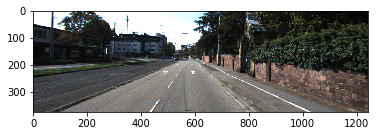

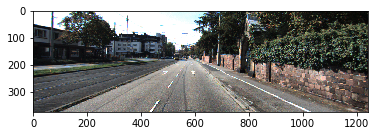

In [5]:
# Helper functions

def clahe(img, clipLimit=1.0, tileGridSize=(4,4)):
    """Apply contrast limited adaptive histogram equalization to an image.
    Parameters
    ----------
    channel : np.ndarray, ndim=3
        Input representation.
    clipLimit : float
        Limit for contrast clipping.
    tileGridSize : 2-tuple
        Size of the kernel.
    Returns
    -------
    Z : np.ndarray
        The contrast adapted image.
    """
    aux_img = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
    aux_img[..., 0] = clahe.apply(aux_img[..., 0])
    aux_img = cv2.cvtColor(aux_img, cv2.COLOR_Lab2RGB)
    return aux_img

def create_gamma_lut(gamma=1.0):
    table = np.array([((i / 255.0) ** gamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
    return table

def adjust_gamma(image, table):
    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

def _preprocess(image):
    image = clahe(image)
    return image

def preprocess(images):
    return [_preprocess(image) for image in images]

def augment(images, labels):
    augmented_imgs = images
    augmented_labels = labels
    for gamma in [0.7, 1.3]:
        table = create_gamma_lut(gamma)
        gamma_imgs = [adjust_gamma(image, table) for image in images]
        augmented_imgs = np.concatenate([augmented_imgs, np.array(gamma_imgs)])
        augmented_labels = np.concatenate([augmented_labels, labels])
    return augmented_imgs, augmented_labels

In [6]:
def train_nn(sess, epochs, batch_size, get_batches_fn, train_op, cross_entropy_loss, input_image,
             correct_label, keep_prob, learning_rate, is_training):
    """
    Train neural network and print out the loss during training.
    :param sess: TF Session
    :param epochs: Number of epochs
    :param batch_size: Batch size
    :param get_batches_fn: Function to get batches of training data.  Call using get_batches_fn(batch_size)
    :param train_op: TF Operation to train the neural network
    :param cross_entropy_loss: TF Tensor for the amount of loss
    :param input_image: TF Placeholder for input images
    :param correct_label: TF Placeholder for label images
    :param keep_prob: TF Placeholder for dropout keep probability
    :param learning_rate: TF Placeholder for learning rate
    :param is_training: TF Placeholder for batch normalization training state
    """
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        print('Epoch:', e)
        for images, labels in get_batches_fn(batch_size):
            pre_images = preprocess(images)
            aug_images, aug_labels = augment(pre_images, labels)
            sess.run(train_op, feed_dict = {input_image: aug_images, correct_label: aug_labels,
                                            keep_prob: 1, learning_rate: 0.0011,
                                            is_training: True})
        loss = sess.run(cross_entropy_loss, feed_dict = {input_image: aug_images, correct_label: aug_labels,
                                            keep_prob: 1, learning_rate: 0.0011,
                                                         is_training: False})
        print('Training loss:', loss)
tests.test_train_nn(train_nn)

Tests Passed


In [7]:
def run():
    num_classes = 2
    image_shape = (160, 576)
    data_dir = './data'
    runs_dir = './runs'
    tests.test_for_kitti_dataset(data_dir)

    # Download pretrained vgg model
    helper.maybe_download_pretrained_vgg(data_dir)

    # OPTIONAL: Train and Inference on the cityscapes dataset instead of the Kitti dataset.
    # You'll need a GPU with at least 10 teraFLOPS to train on.
    #  https://www.cityscapes-dataset.com/
    
    save_model_path = './model/model'
    if not os.path.isdir('./model'):
        os.mkdir('./model')

    with tf.Session() as sess:
        # Path to vgg model
        vgg_path = os.path.join(data_dir, 'vgg')
        # Create function to get batches
        get_batches_fn = helper.gen_batch_function(os.path.join(data_dir, 'data_road/training'), image_shape)

        # OPTIONAL: Augment Images for better results
        #  https://datascience.stackexchange.com/questions/5224/how-to-prepare-augment-images-for-neural-network

        epochs = 50
        batch_size = 10
        correct_label = tf.placeholder(tf.int32, [None, None, None, num_classes], name='correct_label')
        learning_rate = tf.placeholder(tf.float32, name='learning_rate')
        is_training = tf.placeholder(tf.bool, name='is_training')

        x, keep_prob, layer3, layer4, layer7 = load_vgg(sess, vgg_path)
        output = layers(layer3, layer4, layer7, num_classes)
        logits, optimizer, cost = optimize(output, correct_label, learning_rate, num_classes)
        
        train_nn(sess, epochs, batch_size, get_batches_fn, optimizer, cost, x,
             correct_label, keep_prob, learning_rate, is_training)
        saver = tf.train.Saver()
        save_path = saver.save(sess, save_model_path)
        helper.save_inference_samples(runs_dir, data_dir, sess, image_shape, logits, keep_prob, x)
        # OPTIONAL: Apply the trained model to a video


if __name__ == '__main__':
    run()

Tests Passed
INFO:tensorflow:Restoring parameters from b'./data/vgg/variables/variables'
Epoch: 0
Training loss: 0.295036
Epoch: 1
Training loss: 0.198195
Epoch: 2
Training loss: 0.146064
Epoch: 3
Training loss: 0.173679
Epoch: 4
Training loss: 0.153859
Epoch: 5
Training loss: 0.12381
Epoch: 6
Training loss: 0.112098
Epoch: 7
Training loss: 0.0874237
Epoch: 8
Training loss: 0.0721141
Epoch: 9
Training loss: 0.0856165
Epoch: 10
Training loss: 0.0539402
Epoch: 11
Training loss: 0.0661436
Epoch: 12
Training loss: 0.078798
Epoch: 13
Training loss: 0.0580231
Epoch: 14
Training loss: 0.0448191
Epoch: 15
Training loss: 0.0794546
Epoch: 16
Training loss: 0.0779382
Epoch: 17
Training loss: 0.0410007
Epoch: 18
Training loss: 0.0508656
Epoch: 19
Training loss: 0.0337186
Epoch: 20
Training loss: 0.0467756
Epoch: 21
Training loss: 0.0357824
Epoch: 22
Training loss: 0.0342733
Epoch: 23
Training loss: 0.0387942
Epoch: 24
Training loss: 0.0295496
Epoch: 25
Training loss: 0.032813
Epoch: 26
Training lo